In [1]:
%matplotlib inline
import time
import copy
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import gru_ode_bayes 
import gru_ode_bayes.data_utils as data_utils
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from gru_ode_bayes import Logger
import matplotlib.pyplot as plt
from scipy.sparse.csgraph import connected_components

In [2]:
file_path="D:/mimic_iii/clean_data/"
csv_file_path =file_path+"GRU_ODE_Dataset.csv"
covs_file_path=file_path+"GRU_ODE_covariates.csv"
tags_file_path=file_path+"GRU_ODE_death_tags.csv"

In [3]:
import pickle

def pickle_dump(obj, path):
    with open(path, mode='wb') as f:
        pickle.dump(obj,f)

def pickle_load(path):
    with open(path, mode='rb') as f:
        data = pickle.load(f)
        return data

In [4]:
# ロード
d=pickle_load( file_path+'sample_unique_id_dict.pickle')


In [5]:
idx=np.array(list(d.keys()))

In [6]:
dir_path=r"D:/mimic_iii/clean_data/"
test_idx = np.load(dir_path+r"fold_idx_0/test_idx.npy")

## covariateの対応表を作成
(np.argmaxでcovをカテゴリ化する際に、コードがずれるのを防ぐため)

In [7]:
cov_df=pd.read_csv(covs_file_path)

In [8]:
np.argmax(cov_df.iloc[:,1:].to_numpy(), axis=1)

array([199, 199, 200, ..., 320, 190, 416], dtype=int64)

In [9]:
cov_list=list(cov_df.columns)
cov_list.pop(0)

'ID'

In [10]:
cov_dict={}
for i,cov in enumerate(cov_list):
    cov_dict[i]=cov

In [23]:
# # このdictでargmax->ICD9Code化する
# cov_dict

In [24]:
# data_train = data_utils.ODE_Dataset(csv_file=csv_file_path,label_file=tags_file_path, cov_file=covs_file_path, idx=idx)

In [11]:
# testdataを使う場合
data_test   = data_utils.ODE_Dataset(csv_file=csv_file_path,label_file=tags_file_path,
                                    cov_file= covs_file_path, idx=test_idx, validation = False,
                                    val_options =None)

In [12]:
# 全データを使う場合
#data_test   = data_utils.ODE_Dataset(csv_file=csv_file_path,label_file=tags_file_path,
#                                    cov_file= covs_file_path, idx=None, validation = False,
#                                    val_options =None)

In [12]:
dl   = DataLoader(dataset=data_test, collate_fn=data_utils.custom_collate_fn, shuffle=True, batch_size=100,num_workers=4)

In [13]:
#Model parameters.
params_dict=dict()
params_dict["hidden_size"] = 100
params_dict["p_hidden"] = 25
params_dict["prep_hidden"] = 10
params_dict["logvar"] = True
params_dict["mixing"] = 1e-4 #Weighting between KL loss and MSE loss.
params_dict["delta_t"]=0.1
params_dict["T"]= 100  #100
# lambda>0のときClassificationを行う
params_dict["lambda"] = 1 #Weighting between classification and MSE loss.
# lambda==0でないとき、validationオプションはなしにされている(validation==False)
# validationがないときは、summaryのcorrelation,validation_mse,loglik_lossは計算されず0で記録される

params_dict["classification_hidden"] = 2
params_dict["cov_hidden"] = 50
params_dict["weight_decay"] = 0.0001
params_dict["dropout_rate"] = 0
params_dict["lr"]=0.001
params_dict["full_gru_ode"] = True
params_dict["no_cov"] = False # covファイルが存在するときFalse
params_dict["impute"] = False


params_dict["input_size"]=data_test.variable_num
params_dict["cov_size"] = data_test.cov_dim

In [14]:
# model instance 生成
device = torch.device("cuda")
model = gru_ode_bayes.NNFOwithBayesianJumps(input_size = params_dict["input_size"], hidden_size = params_dict["hidden_size"],
                                            p_hidden = params_dict["p_hidden"], prep_hidden = params_dict["prep_hidden"],
                                            logvar = params_dict["logvar"], mixing = params_dict["mixing"],
                                            classification_hidden=params_dict["classification_hidden"],
                                            cov_size = params_dict["cov_size"], cov_hidden = params_dict["cov_hidden"],
                                            dropout_rate = params_dict["dropout_rate"],full_gru_ode= params_dict["full_gru_ode"], impute = params_dict["impute"])
model.to(device)

NNFOwithBayesianJumps(
  (p_model): Sequential(
    (0): Linear(in_features=100, out_features=25, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=25, out_features=192, bias=True)
  )
  (classification_model): Sequential(
    (0): Linear(in_features=100, out_features=2, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=2, out_features=1, bias=True)
  )
  (gru_c): FullGRUODECell_Autonomous(
    (lin_hh): Linear(in_features=100, out_features=100, bias=False)
    (lin_hz): Linear(in_features=100, out_features=100, bias=False)
    (lin_hr): Linear(in_features=100, out_features=100, bias=False)
  )
  (gru_obs): GRUObservationCellLogvar(
    (gru_d): GRUCell(960, 100)
    (gru_debug): GRUCell(960, 100)
  )
  (covariates_map): Sequential(
    (0): Linear(in_features=530, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=50, out_features=100, bias=True

In [16]:
# model parameter load
model_path = r'D:/mimic_iii/clean_data/trained_models/Xval_AUC_GRU_ODE_MIMIC_Binned2_NoImpute_dropout0.1_weightdecay0.0001_lambda1_fold0_MAX.pt'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [17]:
def return_latent(model,x):
    return model.classify_latent(x)


In [18]:
cov_latent_dict=dict()
with torch.no_grad():
    model.eval()
    for i, b in tqdm(enumerate(dl),total=len(dl)):
        times    = b["times"]
        time_ptr = b["time_ptr"]
        X        = b["X"].to(device)
        M        = b["M"].to(device)
        obs_idx  = b["obs_idx"]
        cov_np   = np.argmax(b["cov"].numpy(), axis=1)  #latent_vec取得用
        cov_np   = np.array([cov_dict[i] for i in cov_np])
        cov      = b["cov"].to(device)
        labels   = b["y"].to(device)
        batch_size = labels.size(0)
        if b["X_val"] is not None:
            X_val     = b["X_val"].to(device)
            M_val     = b["M_val"].to(device)
            times_val = b["times_val"]
            times_idx = b["index_val"]
        h0 = 0 #torch.zeros(labels.shape[0], params_dict["hidden_size"]).to(device)
        hT, loss, class_pred, t_vec, p_vec, h_vec, _, _,_,_  = model(times, time_ptr, X, M, obs_idx, delta_t=params_dict["delta_t"], T=params_dict["T"], cov=cov, return_path=True)
        #latent = return_latent(model,hT)
        #cov_latent_dict[i]={"cov": cov_np,"hT":hT.cpu().detach().numpy(),"h0":h_vec.cpu().detach().numpy()[0,:,:],"DimComp_hT": latent.cpu().detach().numpy() ,"y":b["y"].numpy().squeeze()}
        cov_latent_dict[i]={"cov": cov_np,"hT":hT.cpu().detach().numpy(),"h0":h_vec.cpu().detach().numpy()[0,:,:],"y":b["y"].numpy().squeeze()}

  0%|          | 0/22 [00:01<?, ?it/s]


ModuleAttributeError: 'NNFOwithBayesianJumps' object has no attribute 'classify_latent'

In [ ]:
h_vec.shape

In [ ]:
# tmp = dl.__iter__()
# b = tmp.next() 

In [ ]:
# # 1回だけまわす用
# # cov_latent_dict=dict()
# # for i, b in tqdm(enumerate(dl),total=len(dl)):
# times    = b["times"]
# time_ptr = b["time_ptr"]
# X        = b["X"].to(device)
# M        = b["M"].to(device)
# obs_idx  = b["obs_idx"]
# cov_np   = np.argmax(b["cov"].numpy(), axis=1)  #latent_vec取得用
# cov      = b["cov"].to(device)
# labels   = b["y"].to(device)
# batch_size = labels.size(0)
# if b["X_val"] is not None:
#     X_val     = b["X_val"].to(device)
#     M_val     = b["M_val"].to(device)
#     times_val = b["times_val"]
#     times_idx = b["index_val"]
# h0 = 0 #torch.zeros(labels.shape[0], params_dict["hidden_size"]).to(device)
# hT, loss, class_pred, t_vec, p_vec, h_vec, _, _,_,_  = model(times, time_ptr, X, M, obs_idx, delta_t=params_dict["delta_t"], T=params_dict["T"], cov=cov, return_path=True)
# # cov_latent_dict[i]={"cov": cov_np,"hT":hT.cpu().detach().numpy(),"h0":h_vec.cpu().detach().numpy()[0,:,:],"y":b["y"].numpy().squeeze()}

In [ ]:
import pprint
pprint.pprint(cov_latent_dict[0]["DimComp_hT"])

In [ ]:
pickle_dump(cov_latent_dict,file_path+"cov_latent_dict.pickle")

# 潜在変数を用いた分析

In [31]:
cov_latent_dict=pickle_load(file_path+"cov_latent_dict.pickle")

In [32]:
h0=cov_latent_dict[0]['h0']
# hT=cov_latent_dict[0]["DimComp_hT"]
hT=cov_latent_dict[0]["hT"]
cov=cov_latent_dict[0]['cov']
y=cov_latent_dict[0]['y']
for i in range(list(cov_latent_dict.keys())[-1]):
    h0=np.vstack([h0,cov_latent_dict[i+1]['h0']])
#     hT=np.vstack([hT,cov_latent_dict[i+1]["DimComp_hT"]])
    hT=np.vstack([hT,cov_latent_dict[i+1]["hT"]])
    cov=np.append(cov,cov_latent_dict[i+1]['cov'])
    y=np.append(y,cov_latent_dict[i+1]['y'])

In [33]:
h0.shape

(2124, 100)

In [170]:
hT.shape

(2124, 100)

### 画像化

In [81]:
def min_max(x, axis=None):
    min = x.min(axis=axis, keepdims=True)
    max = x.max(axis=axis, keepdims=True)
    result = (x-min)/(max-min)
    return result

In [177]:
from PIL import Image

sample_h0=min_max(h0[0].reshape(10, 10))
pil_img_h0 = Image.fromarray(sample_h0.repeat(50, axis=0).repeat(50, axis=1)*255)
pil_img_h0.show()

In [176]:
sample_hT=min_max(hT[0].reshape(10, 10))
pil_img_hT = Image.fromarray(sample_hT.repeat(50, axis=0).repeat(50, axis=1)*255)
pil_img_hT.show()

In [179]:
sample_diff=min_max(h0[0].reshape(10, 10)-hT[0].reshape(10, 10))
pil_img_diff = Image.fromarray(sample_diff.repeat(50, axis=0).repeat(50, axis=1)*255)
pil_img_diff.show()

画像化ここまで

In [16]:
# h0をクラス予測用モデルから10次元に圧縮
# latent_h0=torch.tensor(h0).to(device)
# latent_h0=return_latent(model,latent_h0).cpu().detach().numpy()
# latent_h0.shape

In [34]:
h0_to_df=pd.DataFrame(h0)

In [35]:
h0_df=pd.DataFrame([cov,y]).T
h0_df.columns=["cov","y"]
h0_df["y"]=h0_df["y"].astype("float")
h0_df_comp=pd.concat([h0_df,h0_to_df],axis=1)
h0_df_agg=h0_df_comp.groupby("cov").mean()
h0_df_agg=h0_df_agg.reset_index()
# h0_df_comp[h0_df_comp["cov"]=="215"].head()

In [36]:
h0_df_agg.head()
# print(len(h0_df_agg))

,cov,y,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,004,0.00,0.288088,0.085631,-0.105374,-0.121079,0.140266,-0.262072,-0.353919,0.015756,...,0.206358,0.036241,-0.036505,0.169087,0.196920,-0.350897,0.347158,-0.346260,-0.198585,0.196227
1,008,0.25,0.377365,0.025479,-0.141680,-0.279264,0.122057,-0.296714,-0.617607,-0.167433,...,0.434276,0.007689,-0.182916,0.154001,0.174587,-0.489178,0.509297,-0.533116,-0.369572,0.155245
2,009,0.00,0.436107,0.022284,-0.112573,0.066373,0.183625,-0.177384,-0.609236,-0.330252,...,0.315731,-0.048989,-0.166508,0.296964,-0.000062,-0.282033,0.559665,-0.448933,-0.310015,0.131802
3,013,0.00,0.438954,0.210865,-0.319568,-0.306447,0.335926,-0.278066,-0.437886,0.140904,...,-0.097702,0.149086,-0.101310,0.449586,0.214276,-0.610927,0.338314,-0.490983,-0.068227,0.390610
4,027,0.00,0.288088,0.085631,-0.105374,-0.121079,0.140266,-0.262072,-0.353919,0.015756,...,0.206358,0.036241,-0.036505,0.169087,0.196920,-0.350897,0.347158,-0.346260,-0.198585,0.196227


In [37]:
# h0を集計後のものに修正
h0=h0_df_agg.iloc[: ,2:].values

In [38]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
h0=scaler.fit_transform(h0)
hT=scaler.fit_transform(hT)

In [22]:
# from sklearn.decomposition import PCA
# pca     = PCA(n_components=2)
# h0_2dim = pca.fit_transform(h0)
# hT_2dim = pca.fit_transform(hT)

In [23]:
# print(pca.explained_variance_ratio_)
# print(pca.singular_values_)

In [24]:
# from sklearn.manifold import TSNE
# tsne=TSNE(n_components=2, random_state=1)
# h0_2dim=tsne.fit_transform(h0)
# hT_2dim=tsne.fit_transform(hT)

In [39]:
# umapのほうがかなり高速なのでtsne->umap
import umap
umap_obj=umap.UMAP(random_state=0, n_neighbors=5)
h0_2dim=umap_obj.fit_transform(h0)
hT_2dim=umap_obj.fit_transform(hT)

## 病種での死亡率

In [104]:
h0_2dim_df=pd.DataFrame(h0_2dim)
len(h0_2dim_df)

282

In [105]:
h0_df_agg.iloc[: ,0]

0      004
1      008
2      009
3      013
4      027
      ... 
277    998
278    999
279    V58
280    V59
281    V71
Name: cov, Length: 282, dtype: object

In [106]:
h0_mean=pd.concat([h0_df_agg.iloc[: ,0:2],h0_2dim_df],axis=1)
h0_mean.columns=["cov", "y","h0_x","h0_y"]
h0_mean

,cov,y,h0_x,h0_y
0,004,0.000000,13.363650,5.296232
1,008,0.250000,6.211942,3.702046
2,009,0.000000,6.212218,0.836343
3,013,0.000000,0.085379,4.800626
4,027,0.000000,13.453493,5.384959
...,...,...,...,...
277,998,0.083333,13.676200,5.654768
278,999,0.000000,7.492777,5.017741
279,V58,0.000000,7.971522,2.579356
280,V59,0.000000,3.629710,7.886538


In [107]:
h0_mean.iloc[:,2:4]

,h0_x,h0_y
0,13.363650,5.296232
1,6.211942,3.702046
2,6.212218,0.836343
3,0.085379,4.800626
4,13.453493,5.384959
...,...,...
277,13.676200,5.654768
278,7.492777,5.017741
279,7.971522,2.579356
280,3.629710,7.886538


In [108]:
h0_mean=pd.concat([h0_df_agg.iloc[: ,0:2],h0_2dim_df],axis=1)
h0_mean.columns=["cov", "y","h0_x","h0_y"]
h0_mean

,cov,y,h0_x,h0_y
0,004,0.000000,13.363650,5.296232
1,008,0.250000,6.211942,3.702046
2,009,0.000000,6.212218,0.836343
3,013,0.000000,0.085379,4.800626
4,027,0.000000,13.453493,5.384959
...,...,...,...,...
277,998,0.083333,13.676200,5.654768
278,999,0.000000,7.492777,5.017741
279,V58,0.000000,7.971522,2.579356
280,V59,0.000000,3.629710,7.886538


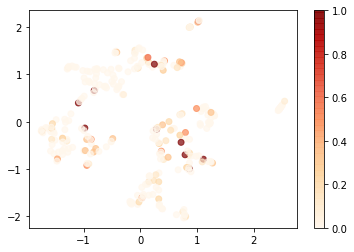

In [109]:
h0_mean.iloc[:,2:4]=scaler.fit_transform(h0_mean.iloc[:,2:4])
plt.scatter(h0_mean["h0_x"],h0_mean["h0_y"],c=h0_mean["y"],cmap='OrRd',alpha=0.7)
plt.colorbar()

## hTでの病種別重心と死亡率

In [41]:
df=pd.DataFrame([cov,y,hT_2dim[:,0],hT_2dim[:,1]]).T

In [42]:
df.columns=["cov","y","hT_x","hT_y"]

In [43]:
df.head()

,cov,y,hT_x,hT_y
0,430,0,13.3531,9.59222
1,414,0,10.8565,2.13785
2,803,0,13.1128,6.15343
3,410,0,5.61271,2.36626
4,084,0,9.04159,9.52907


In [44]:
df["y"]=df["y"].astype(float)
df["hT_x"]=df["hT_x"].astype(float)
df["hT_y"]=df["hT_y"].astype(float)
hT_stat=df.groupby("cov").mean()

Text(0.5, 1.0, 'Mortality')

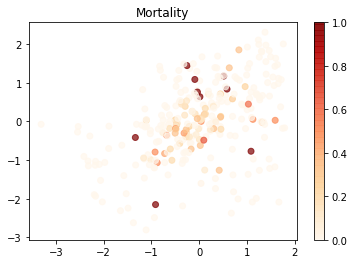

In [45]:
hT_stat.iloc[:,1:3]=scaler.fit_transform(hT_stat.iloc[:,1:3])
plt.scatter(hT_stat["hT_x"],hT_stat["hT_y"],c=hT_stat["y"],cmap='OrRd',alpha=0.7)
plt.colorbar()
plt.title("Mortality")

## hTでの全点表示(一応)

In [46]:
df.iloc[:,2:4].head()

,hT_x,hT_y
0,13.353145,9.592216
1,10.856549,2.137850
2,13.112794,6.153425
3,5.612713,2.366258
4,9.041592,9.529071


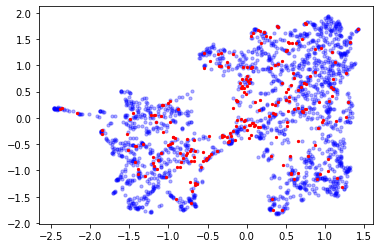

In [47]:
c=["blue","red"]
alpha=[0.3,1]
s=[10,5]
df.iloc[:,2:4]=scaler.fit_transform(df.iloc[:,2:4])
for i in range(0,2):
    plt.scatter(df[df["y"]==i]["hT_x"],df[df["y"]==i]["hT_y"],s=s[i],color=c[i],alpha=alpha[i])


In [48]:
width=0.1 # 区間幅
xmax=np.ceil(df["hT_x"].max())
xmin=np.floor(df["hT_x"].min())
ymax=np.ceil(df["hT_y"].max())
ymin=np.floor(df["hT_y"].min())
print(xmax,xmin)
print(ymax,ymin)
x=np.arange(xmin,xmax+width,width)
y=np.arange(ymin,ymax+width,width)
X,Y=np.meshgrid(x,y)
value=np.empty_like(X)
print(value.shape)

2.0 -3.0
2.0 -2.0
(41, 51)


In [49]:
for i in tqdm(range(len(y))):
    for j in range(len(x)):
        d=df[(df["hT_x"]>=x[j])& (df["hT_x"]<x[j]+width) & (df["hT_y"]>=y[i]) &(df["hT_y"]<y[i]+width)]
        if d.empty:
#            print("None")
            value[i,j]=0
        else:
#             print(d["y"].mean())
            value[i,j]=d["y"].mean()

100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 30.05it/s]


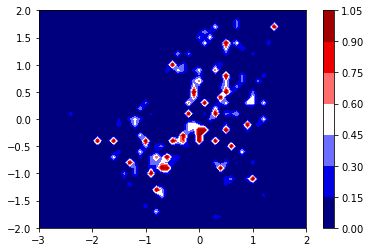

In [50]:
plt.contourf(X, Y, value,cmap="seismic")
plt.colorbar()

## 危険度マップ逆生成

In [83]:
h0_mapper=umap_obj.fit(h0)
xx=X.reshape(len(x)*len(y),1)
yy=Y.reshape(len(x)*len(y),1)
test_pts=np.hstack((xx,yy))
len(test_pts)
inv_transformed_points = h0_mapper.inverse_transform(test_pts)
inv_h0=torch.tensor(inv_transformed_points)
pred=torch.sigmoid(model.classification_model(inv_h0.to(device)))
pred=pred.cpu().detach().numpy()
pts_val=np.empty((41, 51))
idx=0
for i in tqdm(range(len(y))[::-1]):
    for j in range(len(x))[::-1]:
        pts_val[i,j]=pred[idx]
        idx+=1

100%|███████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 40983.43it/s]


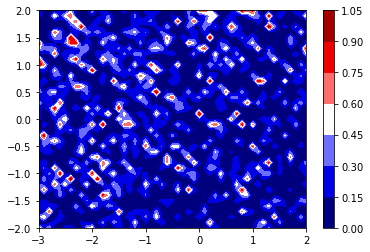

In [84]:
plt.contourf(X, Y, min_max(pts_val),cmap="seismic")
plt.colorbar()

In [76]:
hT_mapper=umap_obj.fit(hT)
xx=X.reshape(len(x)*len(y),1)
yy=Y.reshape(len(x)*len(y),1)
test_pts=np.hstack((xx,yy))
len(test_pts)
inv_transformed_points = hT_mapper.inverse_transform(test_pts)
inv_hT=torch.tensor(inv_transformed_points)
pred=torch.sigmoid(model.classification_model(inv_hT.to(device)))
pred=pred.cpu().detach().numpy()
pts_val=np.empty((41, 51))
idx=0
for i in tqdm(range(len(y))[::-1]):
    for j in range(len(x))[::-1]:
        pts_val[i,j]=pred[idx]
        idx+=1

100%|███████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 40993.20it/s]


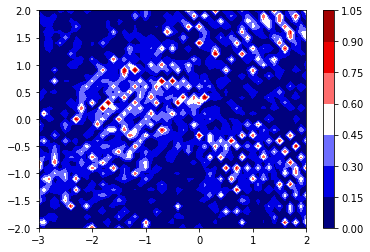

In [82]:
plt.contourf(X, Y, min_max(pts_val),cmap="seismic")
plt.colorbar()

## 病種を大分類に

In [116]:
# ICD9をshortcodeからさらに大分類に分ける a-rまで
def classifyICD(code):
    if code.isdecimal():
        code=int(code)
        if code <=139:
            return "a" #infectious and parasitic diseases
        elif code<=239:
            return "b" #neoplasms
        elif code<=279:
            return "c" #endocrine, nutritional and metabolic diseases, and immunity disorders
        elif code<=289:
            return "d" #Diseases of the Blood and Blood-forming Organs
        elif code<=319:
            return  "e"#Mental Disorders
        elif code<= 359:
            return "f"# diseases of the nervous system
        elif code<= 389:
            return  "g"#sense organs
        elif code<= 459:
            return "h"# Diseases of the Circulatory System
        elif code<= 519 :
            return  "i"# Diseases of the Respiratory System
        elif code<= 579:
            return "j"# Diseases of the Digestive System
        elif code<= 629:
            return "k"# Diseases of the Genitourinary System
        elif code<= 679:
            return  "l"# Complications of Pregnancy, Childbirth, and the Puerperium
        elif code<= 709:
            return "m"#Diseases of the Skin and Subcutaneous Tissue
        elif code<= 739:
            return  "n"# Diseases of the Musculoskeletal System and Connective Tissue
        elif code<= 759:
            return  "o"# Congenital Anomalies
        elif code<= 779:
            return  "p"#Certain Conditions originating in the Perinatal Period
        elif code<= 799:
            return  "q"#Symptoms, Signs and Ill-defined Conditions
        elif code<= 999:
            return  "r"#Injury and Poisoning
    else:
        return "others"

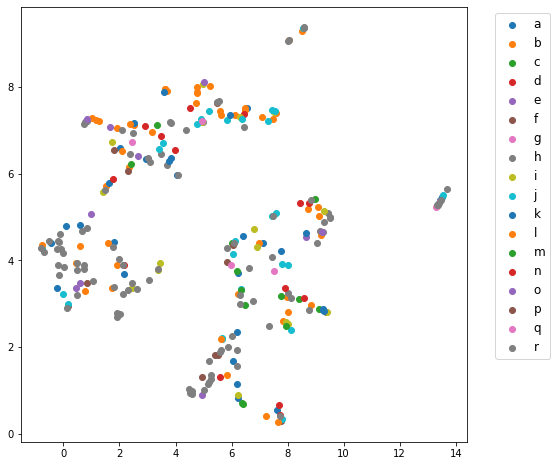

In [117]:
h0_mean=pd.concat([h0_df_agg.iloc[: ,0:2],h0_2dim_df],axis=1)
h0_mean.columns=["cov", "y","h0_x","h0_y"]
h0_mean["category"]=h0_mean["cov"].map(classifyICD)
plt.figure(figsize=(8,8))
for char in "abcdefghijklmnopqr":
    plt.scatter(h0_mean[h0_mean["category"]==char]["h0_x"],h0_mean[h0_mean["category"]==char]["h0_y"],label=char)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=12)

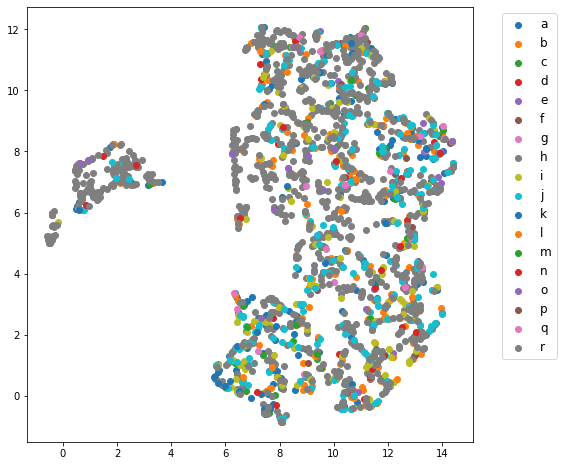

In [118]:
df_hT=copy.deepcopy(df)
df_hT["category"]=df_hT["cov"].map(classifyICD)
df_hT.head()
plt.figure(figsize=(8,8))
for char in "abcdefghijklmnopqr":
    plt.scatter(df_hT[df_hT["category"]==char]["hT_x"],df_hT[df_hT["category"]==char]["hT_y"],label=char)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=12)

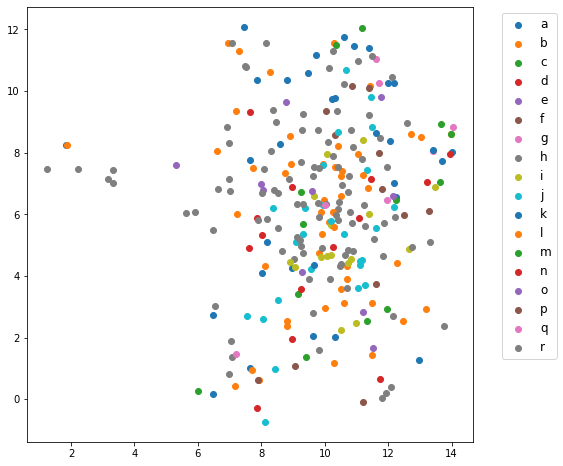

In [119]:
df_hT=copy.deepcopy(df)
df_hT=df_hT.groupby("cov").mean().reset_index()
df_hT["category"]=df_hT["cov"].map(classifyICD)
plt.figure(figsize=(8,8))
for char in "abcdefghijklmnopqr":
    plt.scatter(df_hT[df_hT["category"]==char]["hT_x"],df_hT[df_hT["category"]==char]["hT_y"],label=char)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=12)

## UMAP

In [ ]:
import umap
umap_obj=umap.UMAP()
h0_2dim=umap_obj.fit_transform(h0)
hT_2dim=umap_obj.fit_transform(hT)

## 病種での死亡率(h0)

In [ ]:
h0_2dim_df=pd.DataFrame(h0_2dim)
len(h0_2dim_df)

In [ ]:
h0_df_agg.iloc[: ,0]

In [ ]:
h0_mean=pd.concat([h0_df_agg.iloc[: ,0:2],h0_2dim_df],axis=1)
h0_mean.columns=["cov", "y","h0_x","h0_y"]
h0_mean

In [ ]:
plt.scatter(h0_mean["h0_x"],h0_mean["h0_y"],c=h0_mean["y"],cmap='Reds')
plt.colorbar()

## hTでの病種別重心と死亡率

In [ ]:
df=pd.DataFrame([cov,y,hT_2dim[:,0],hT_2dim[:,1]]).T

In [ ]:
df.columns=["cov","y","hT_x","hT_y"]

In [ ]:
df["y"]=df["y"].astype(float)
df["hT_x"]=df["hT_x"].astype(float)
df["hT_y"]=df["hT_y"].astype(float)
hT_stat=df.groupby("cov").mean()

In [ ]:
plt.scatter(hT_stat["hT_x"],hT_stat["hT_y"],c=hT_stat["y"],cmap='seismic')
plt.colorbar()
plt.title("Mortality")

In [ ]:
plt.scatter(hT_stat["hT_x"],hT_stat["hT_y"],c=list(hT_stat.index),cmap='seismic')
plt.colorbar()
plt.title("cov")

In [121]:
def draw_umap(data,label ,n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    fig = plt.figure(figsize=(8,8))
    cmap="cool"
    if n_components == 1:
#         ax = fig.add_subplot(111)
        plt.scatter(u[:,0], range(len(u)), c=label,cmap=cmap)
        plt.colorbar()
    if n_components == 2:
#         ax = fig.add_subplot(111)
        plt.scatter(u[:,0], u[:,1],c=label,cmap=cmap)
        plt.colorbar()
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c=label, s=100,cmap=cmap)


    plt.title(title, fontsize=18)

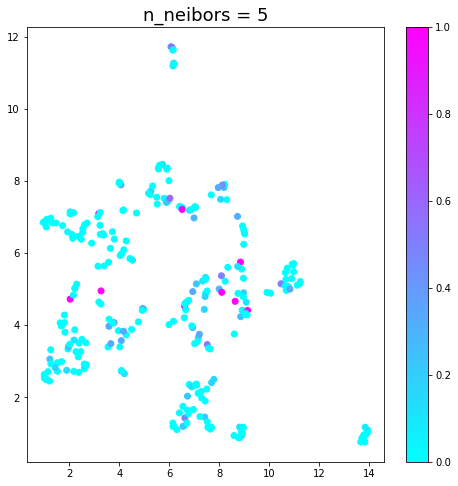

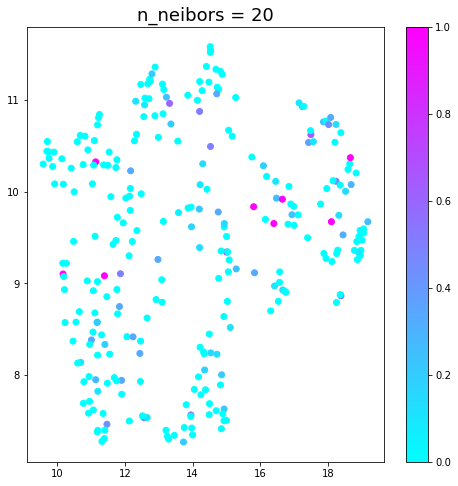

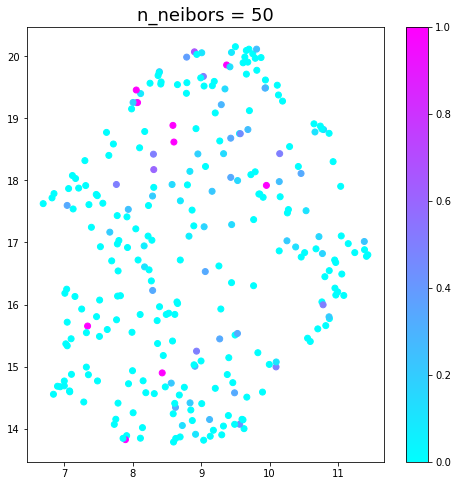

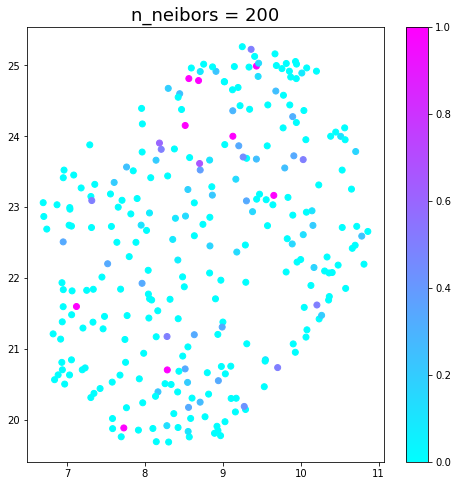

In [122]:
for n in ( 5,  20, 50,  200):
    draw_umap(h0,h0_mean["y"],n_neighbors=n ,title=f"n_neibors = {n}")

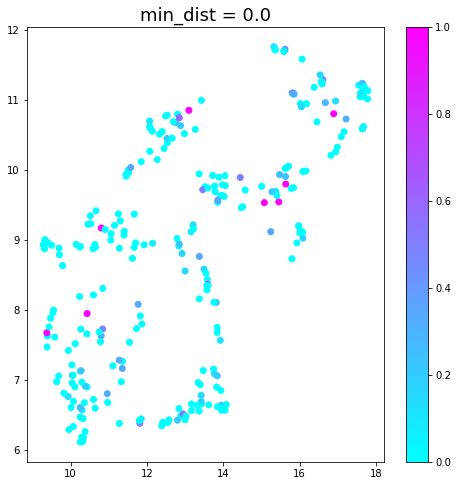

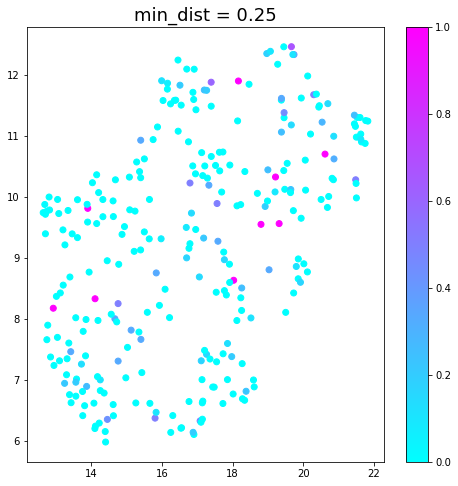

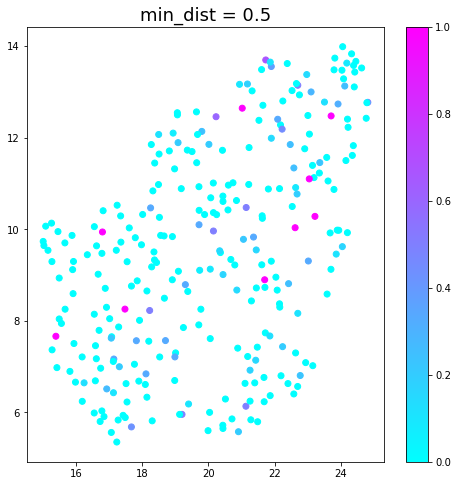

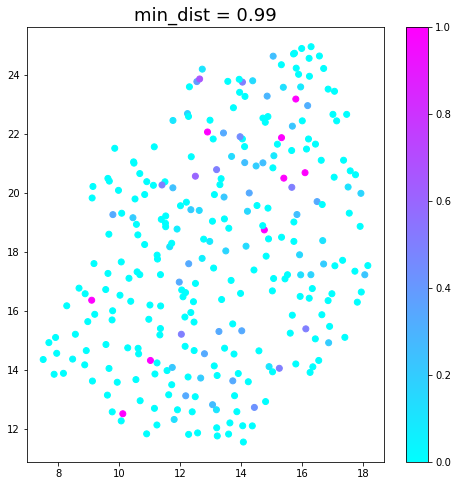

In [123]:
for d in (0.0,  0.25, 0.5, 0.99):
    draw_umap(h0,h0_mean["y"], min_dist=d , title='min_dist = {}'.format(d))

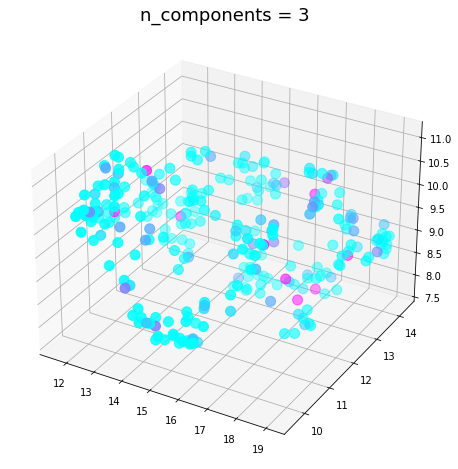

In [124]:
draw_umap(h0,h0_mean["y"],min_dist=0.2,n_components=3, title='n_components = 3')